### Importing necessary modules and libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os
from os.path import abspath, join
from IPython.display import display, display_markdown
import cv2
import matplotlib.pyplot as plt

import torch
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid

CURRENT_DIR = os.path.abspath('')
PARENT = os.path.dirname(CURRENT_DIR)
RUNS = join(PARENT, "runs/")
sys.path.append(PARENT)

In [2]:
from learnable_typewriter.utils.loading import load_pretrained_model
from learnable_typewriter.data.dataloader import collate_fn_pad_to_max

### Inference: 
### As inference we denote the production of the following information out of a given input $x$:
- Reconstruction
- Semantic Segmentation
- Labelling

### Using the `decompositor` module we can produce all the required reconstruction and semantic segmentation information.  
To just obtain reconstruction we can also use the `xp = model.predict_cell_per_cell(x)` function.  
Finally to infer the ground truth characters we use the `trainer.inference(x, xp)` module (where the second argument can be ommitted in the expense of recomputing it internally).

In [3]:
#separer la fonction qui trouve la ligne du dataset
def get_line(loader, idx):
    ds = loader[0].dataset[idx] #idx = the specific data sample you want to perform inference on
    x = collate_fn_pad_to_max([ds], supervised=True) # forms a batch of a single element
    return x

def inference_from_line(decompositor, x):
    obj = decompositor(x)
    gt, rec, sgm = [to_pil_image(a.cpu()[0]) for a in [x['x'], obj['reconstruction'], obj['segmentation']]]
    rec = to_pil_image(obj['reconstruction'].cpu()[0])
    sgm = to_pil_image(obj['segmentation'].cpu()[0])
    x_image = to_pil_image(x['x'].cpu()[0])
    return x_image, rec, sgm

def inference(trainer, idx):
    ds = trainer.train_loader[0].dataset[idx] #idx = the specific data sample you want to perform inference on
    x = collate_fn_pad_to_max([ds], supervised=True) # forms a batch of a single element
    print(x.keys())

    obj = trainer.decompositor(x)
    gt, rec, sgm = [to_pil_image(a.cpu()[0]) for a in [x['x'], obj['reconstruction'], obj['segmentation']]]

    #transcribe = trainer.transcribe_unsupervised if trainer.unsupervised else trainer.transcribe
    #gt_txt, pred_txt = '', ''
    #''.join([trainer.transcribe_dataset[t] for t in x['y'][0]]), ''.join([transcribe[t] for t in trainer.inference(x, obj)[0]])
    return gt, rec, sgm, gt_txt, pred_txt

### We also plot the sprites of the model associated with the colors they have on the semantic segmentation. This can help us identify which sprite is being used and whether multiple sprites are overlayed.

In [4]:
def plot_bnw_sprites(trainer, n_row=21, n_z=0):
    masks = trainer.model.masks#[0:40]

    # Reverse the colors of the masks
    masks = 1 - masks

    #print(masks.shape)

    pad = n_z * [torch.ones_like(masks[0].unsqueeze(0))]
    masks = torch.cat([masks[i].unsqueeze(0) for i in range(masks.size()[0])] + pad, dim=0)
    return to_pil_image(make_grid(masks, nrow=n_row, padding_value=1, padding=2))

### Import trainers/pretrained models with load_pretrained_model

### trainer = load_pretrained_model(path=model_path, device=None)

In [6]:
iwcp_trainer = load_pretrained_model(join(RUNS, '/home/vlachoum/learnable-scriber/finetune_runs/iwcp_south_north_individual_v3/Arras-861/'), device=None)
display(plot_bnw_sprites(iwcp_trainer))

KeyError: 'supervised'

In [7]:
arras_masks = arras_trainer.model.masks
arras_masks = 1 - arras_masks

print("Shape:", arras_masks.shape) #59=nb de sprites, 1 channel(grayscale image), 48x48 dimensions
print("Data type:", arras_masks.dtype) #float32
print("Example:\n", arras_masks[0])

Shape: torch.Size([59, 1, 48, 48])
Data type: torch.float32
Example:
 tensor([[[0.9998, 0.9997, 0.9998,  ..., 0.9990, 0.9991, 0.9989],
         [0.9997, 0.9997, 0.9997,  ..., 0.9988, 0.9985, 0.9990],
         [0.9998, 0.9997, 0.9998,  ..., 0.9966, 0.9977, 0.9983],
         ...,
         [0.9997, 0.9995, 0.9994,  ..., 0.9999, 0.9999, 0.9999],
         [0.9998, 0.9997, 0.9997,  ..., 0.9999, 1.0000, 1.0000],
         [0.9999, 0.9999, 0.9999,  ..., 1.0000, 1.0000, 1.0000]]],
       grad_fn=<SelectBackward0>)


### print a sprite separately

Text(0.5, 1.0, 'd_arras')

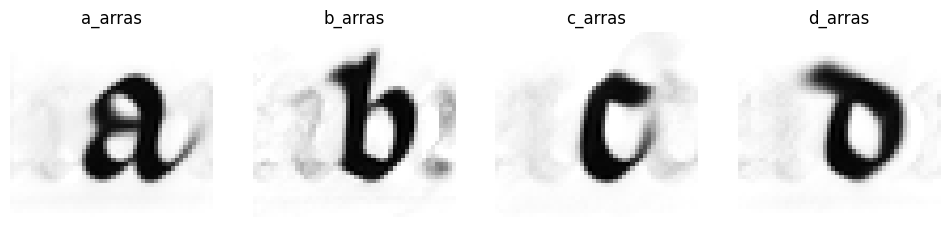

In [8]:
### print a sprite separately

a_arras = arras_masks[20].squeeze().detach().cpu().numpy()  # Convert to a NumPy array
b_arras = arras_masks[21].squeeze().detach().cpu().numpy()  
c_arras = arras_masks[22].squeeze().detach().cpu().numpy()  
d_arras = arras_masks[23].squeeze().detach().cpu().numpy()  


fig, ax = plt.subplots(1, 4, figsize=(12, 4))

ax[0].imshow(a_arras, cmap='gray')
ax[0].axis('off')
ax[0].set_title('a_arras')
ax[1].imshow(b_arras, cmap='gray')
ax[1].axis('off')
ax[1].set_title('b_arras')
ax[2].imshow(c_arras, cmap='gray')
ax[2].axis('off')
ax[2].set_title('c_arras')
ax[3].imshow(d_arras, cmap='gray')
ax[3].axis('off')
ax[3].set_title('d_arras')


## Line reconstructions


In [10]:
from learnable_typewriter.typewriter.model import LearnableTypewriter
from learnable_typewriter.typewriter.inference import InferenceSupervised
from learnable_typewriter.typewriter.optim.loss import Loss
from learnable_typewriter.evaluate.qualitative.decompositor import Decompositor

In [11]:
#Define the loader and the decompositor
arras_loader = arras_trainer.train_loader
arras_decompositor = arras_trainer.decompositor

In [11]:
from IPython.display import display
import os
import numpy as np
from PIL import Image

def remove_alpha_channel(image):
    # Convert PIL Image to NumPy array
    image_array = np.array(image)
    
    # Remove the alpha channel
    image_rgb_array = image_array[:, :, :3]
    
    # Convert NumPy array back to PIL Image
    image_rgb = Image.fromarray(image_rgb_array)
    
    return image_rgb

def perform_inference_on_dataset(loader, decompositor, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    max_width = 0  # Initialize max_width variable

    for idx in range(len(loader[0].dataset)):
        # Get a line from the dataset
        x = get_line(loader, idx)

        # Perform inference on the line
        x_image, rec, sgm = inference_from_line(decompositor, x)
        x_image_rgb = remove_alpha_channel(x_image)

        # Update max_width if the current width is greater
        max_width = max(max_width, x_image.size[0])

        # Create a new blank image with the desired dimensions and a transparent background
        result_width = max_width
        result_height = 96 * 4
        result = Image.new("RGBA", (result_width, result_height), (255, 255, 255, 0))

        # Paste images onto the blank image
        result.paste(x_image, (0, 0))
        result.paste(Image.new("RGB", x_image_rgb.size, (255, 255, 255)), (0, 96))  # Add a white spacer for x_image_rgb
        result.paste(x_image_rgb, (0, 96))
        result.paste(rec, (0, 2 * 96))
        result.paste(sgm, (0, 3 * 96))

        # Save the result with a unique name in the output folder
        output_path = os.path.join(output_folder, f"output_grid_{idx}.png")
        result.save(output_path)

        # Display the result
        result.show()

{0: '.', 1: ':', 2: 'A', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'H', 8: 'I', 9: 'J', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P', 15: 'Q', 16: 'R', 17: 'S', 18: 'T', 19: 'V', 20: 'a', 21: 'b', 22: 'c', 23: 'd', 24: 'e', 25: 'f', 26: 'g', 27: 'h', 28: 'i', 29: 'j', 30: 'l', 31: 'm', 32: 'n', 33: 'o', 34: 'p', 35: 'q', 36: 'r', 37: 's', 38: 't', 39: 'u', 40: 'x', 41: 'y', 42: 'Ñ', 43: 'ã', 44: 'ñ', 45: 'õ', 46: 'ĩ', 47: 'ũ', 48: '̃', 49: '̾', 50: 'ͣ', 51: 'ͤ', 52: 'ͥ', 53: 'ͦ', 54: 'ͬ', 55: '᷑', 56: 'ᷤ', 57: 'ẽ', 58: '⁊', 59: 'ꝑ', 60: 'ꝓ', 61: 'ꝙ', 62: 'ꝯ', 63: 'ꝰ', 64: 'ꝵ', 65: '\uf1ac'}


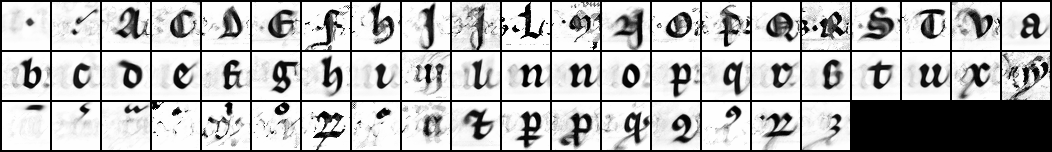

In [7]:
arras_clamp_trainer = load_pretrained_model(join(RUNS, '/home/vlachoum/learnable-scriber/runs/cremma_masks/arras-mask-clamp-0.1-3/2023-12-08_16-01-09'))
display(plot_bnw_sprites(arras_clamp_trainer))
arras_clamp_loader = arras_clamp_trainer.train_loader
arras_clamp_decompositor = arras_clamp_trainer.decompositor
output_folder_path = "/home/vlachoum/learnable-scriber/notebooks/results/arras_clamp/"
#perform_inference_on_dataset(arras_clamp_loader, arras_clamp_decompositor, output_folder_path)

{0: '.', 1: ':', 2: 'A', 3: 'E', 4: 'I', 5: 'J', 6: 'L', 7: 'M', 8: 'N', 9: 'O', 10: 'P', 11: 'Q', 12: 'S', 13: 'T', 14: 'V', 15: 'a', 16: 'b', 17: 'c', 18: 'd', 19: 'e', 20: 'f', 21: 'g', 22: 'h', 23: 'i', 24: 'j', 25: 'l', 26: 'm', 27: 'n', 28: 'o', 29: 'p', 30: 'q', 31: 'r', 32: 's', 33: 't', 34: 'u', 35: 'v', 36: 'x', 37: 'y', 38: 'z', 39: 'ã', 40: 'õ', 41: 'ĩ', 42: '̃', 43: '̾', 44: 'ͣ', 45: 'ẜ', 46: 'ẽ', 47: '⁊', 48: '⁋', 49: 'ꝑ', 50: 'ꝯ', 51: 'ꝰ'}


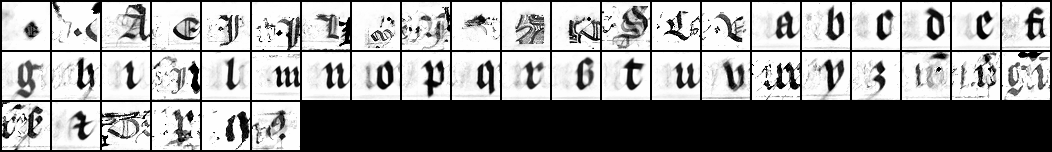

In [8]:
fr246_trainer = load_pretrained_model(join(RUNS, 'textualis_formata_mask/Fr246-mask-clamp-0.1-3/2023-12-11_12-58-55'), device=None)
display(plot_bnw_sprites(fr246_trainer))
fr246_loader = fr246_trainer.train_loader
fr246_decompositor = fr246_trainer.decompositor

In [13]:
output_folder_path = "/home/vlachoum/learnable-scriber/notebooks/results/fr246_clamp/"
perform_inference_on_dataset(fr246_loader, fr246_decompositor, output_folder_path)

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

In [12]:
#Define the loader and the decompositor
iwcp_trainer_loader = iwcp_trainer.train_loader
iwcp_trainer_decompositor = iwcp_trainer.decompositor

In [13]:
output_folder_path = "/home/vlachoum/learnable-scriber/notebooks/results/iwcp_0.001-4/"
perform_inference_on_dataset(iwcp_trainer_loader, iwcp_trainer_decompositor, output_folder_path)

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

In [17]:
arras_wett_new_trainer_loader = arras_wett_new_trainer.train_loader
arras_wett_new_trainer_decompositor = arras_wett_new_trainer.decompositor

In [18]:
output_folder_path = "/home/vlachoum/learnable-scriber/notebooks/results/arras_wett_0.001-4/"
perform_inference_on_dataset(arras_wett_new_trainer_loader, arras_wett_new_trainer_decompositor, output_folder_path)

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
Error: no "view" rule for type "image/png" passed its test case
       (for more in

# Fr412 on masked dataset

{0: '.', 1: ':', 2: 'A', 3: 'E', 4: 'I', 5: 'J', 6: 'L', 7: 'M', 8: 'N', 9: 'O', 10: 'P', 11: 'Q', 12: 'S', 13: 'T', 14: 'V', 15: 'a', 16: 'b', 17: 'c', 18: 'd', 19: 'e', 20: 'f', 21: 'g', 22: 'h', 23: 'i', 24: 'j', 25: 'l', 26: 'm', 27: 'n', 28: 'o', 29: 'p', 30: 'q', 31: 'r', 32: 's', 33: 't', 34: 'u', 35: 'v', 36: 'x', 37: 'y', 38: 'z', 39: 'ã', 40: 'õ', 41: 'ĩ', 42: '̃', 43: '̾', 44: 'ͣ', 45: 'ẜ', 46: 'ẽ', 47: '⁊', 48: '⁋', 49: 'ꝑ', 50: 'ꝯ', 51: 'ꝰ'}


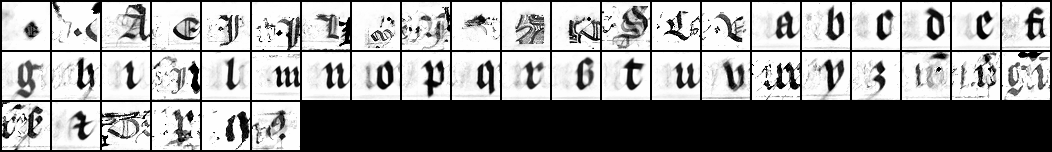

In [12]:
fr412_new_trainer = load_pretrained_model(join(RUNS, 'textualis_formata_mask/Fr246-mask-clamp-0.1-3/2023-12-11_12-58-55'), device=None)
display(plot_bnw_sprites(fr412_new_trainer))

In [13]:
fr412_new_loader = fr412_new_trainer.train_loader
fr412_new_decompositor = fr412_new_trainer.decompositor

In [15]:
#perform_inference_on_dataset(fr412_new_loader, fr412_new_decompositor) 